# Debugging code

This notebook serves as  testbed for the code written in the separate python files. Here I test the different functions with their inputs and use possible error messages to debug. 

In [1]:
# General imports
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

# import code
from plotting import plotting
from riemann import riemann

In [2]:
# initialize necessary classes

mu = 1.0 # set to 1 for convenience
T = 1.0 # set to 1 for convenience

# Riemann initial conditions
rho_L = 1.  # x < 0
rho_R = 1.  # x > 0

v_L = 1
v_R = 0.

# insert momentum in U vector
U_L = (rho_L, v_L*rho_L)
U_R = (rho_R, v_R*rho_R)

plots = plotting(rho_L, rho_R, v_L, v_R)

## Plotting class
Here I will test the different plotting functionality I have added to this class.

In [3]:
def solve(rho_L, rho_R, v_L, v_R):
    plots = plotting(rho_L, rho_R, v_L, v_R)
    plots.full_solution()

{'1-wave': 'shock', '2-wave': 'shock'}


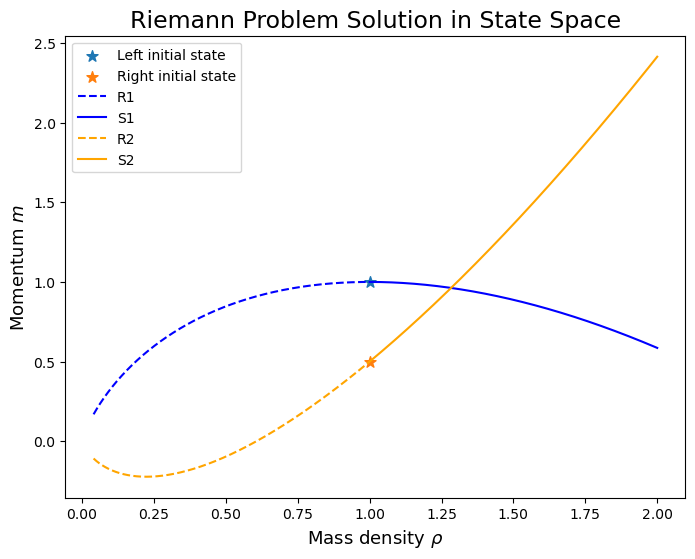

In [4]:
solve(1,1,1, 0.5)

{'1-wave': 'rarefaction', '2-wave': 'shock'}


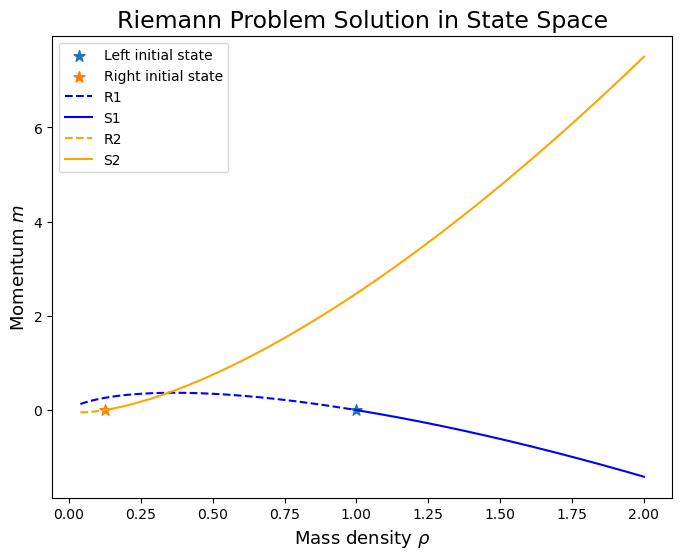

In [5]:
# test 1

solve(1, 0.125, 0, 0)

{'1-wave': 'shock', '2-wave': 'shock'}


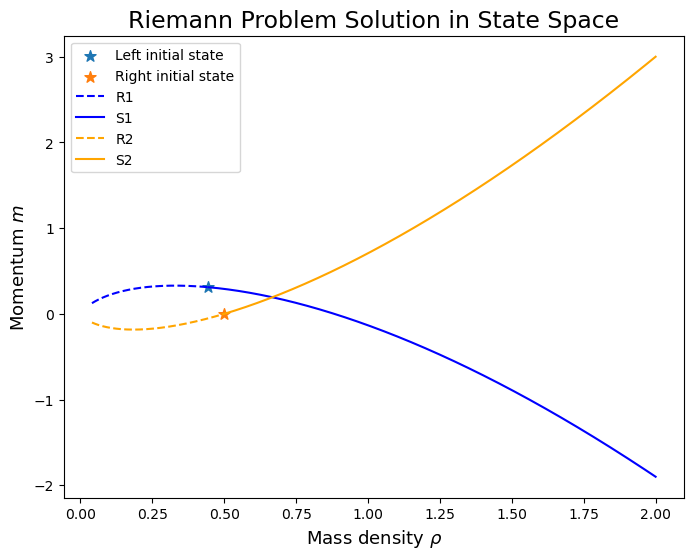

In [6]:
# test 2
solve(0.445, 0.5, 0.31061/0.445, 0)

{'1-wave': 'rarefaction', '2-wave': 'rarefaction'}


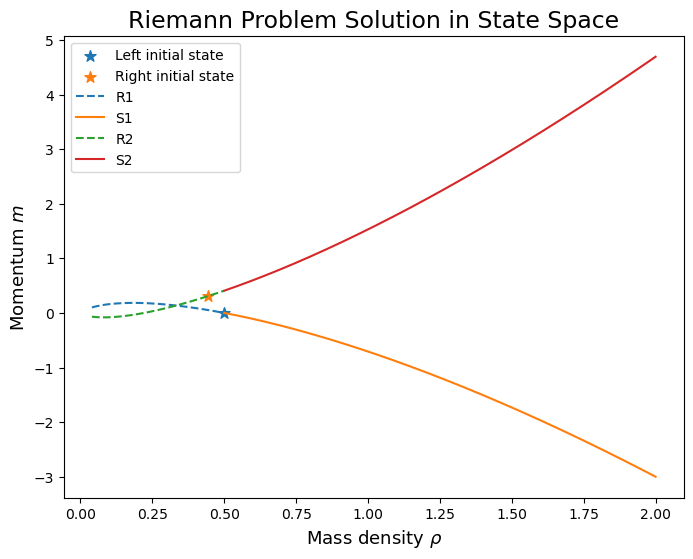

In [7]:
solve(0.5, 0.445, 0, 0.31061/0.445)

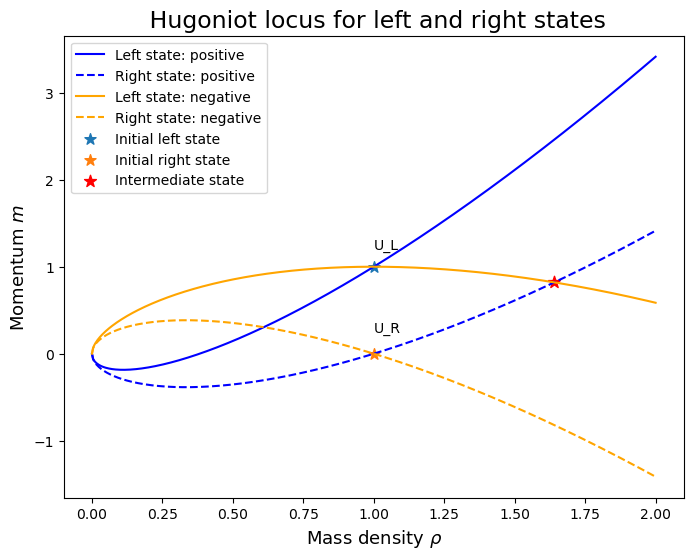

In [5]:
# plot hugoniot locus for left and right states
plots.plot_2_hugoniot_loci(U_L, U_R, intermediate=True)

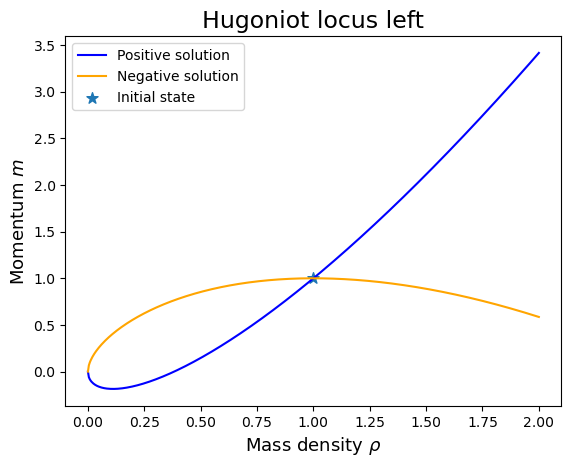

In [6]:
# we plot the Hugoniot locus for a given state U
title = "Hugoniot locus left"
plots.plot_Hugoniot_locus(U_L, title=title)

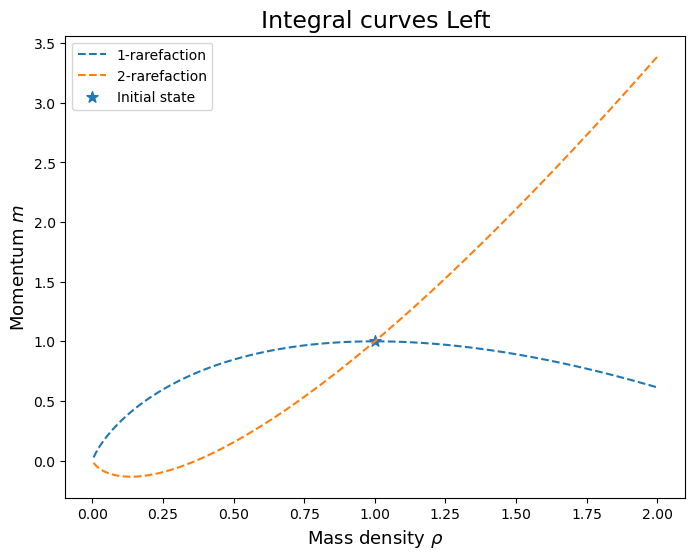

In [7]:
# plot integrl curves
plots.plot_integral_curves(U_L, title='Integral curves Left')

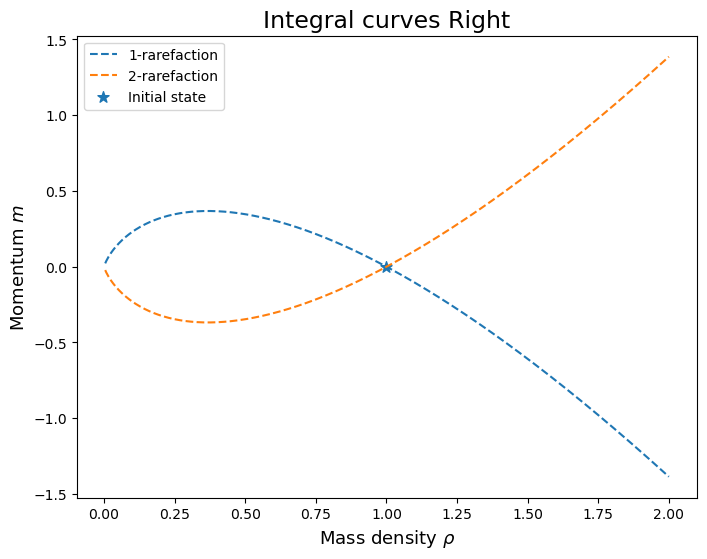

In [8]:
plots.plot_integral_curves(U_R, title='Integral curves Right')

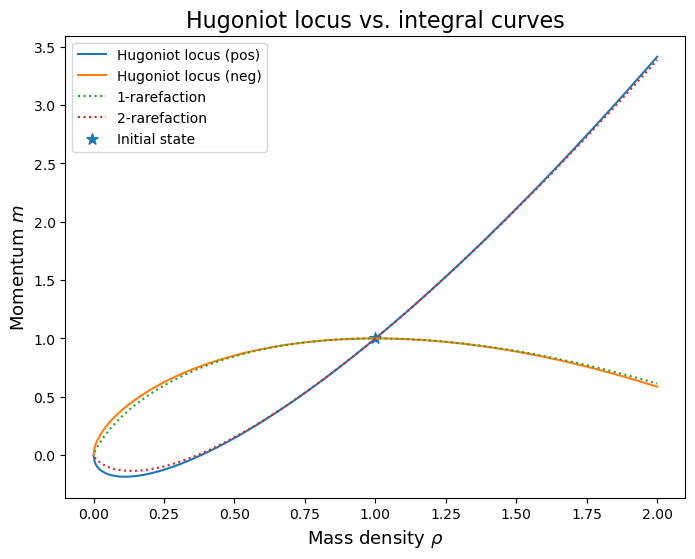

In [10]:
plots.plot_integral_hugoniot(np.array([1,1]), title='Hugoniot locus vs. integral curves',
                   name='integral_hugoniot')

In [ ]:
plots.plot_integral_hugoniot(U_L, 
                             title='Hugoniot locus vs. integral curve: Left',
                             name='Hugoniot_integral_left')

In [ ]:
plots.plot_integral_hugoniot(U_R, 
                             title='Hugoniot locus vs. integral curve: Right',
                             name='Hugoniot_integral_right')

We see that the integral curves do not even go through the initial state on whhich they are based. Likely there is something wrong with the domain of the parameters in U_R for this case. The figures seem to have similar behaviour, only there is a scaling factor or something like that missing.

Problem solved: we should keep in mind that U[1] is the momentum, so when we need the velocity we actually need U[1]/U[0].

In [ ]:
plots.plot_Hugoniot_locus_derivative(U_L,
                                    name='Hugoniot_curve_left')

In [ ]:
plots.plot_Hugoniot_locus_derivative(U_R,
                                    name='Hugoniot_curve_right')

In [ ]:
plots.Plot_Rankine_hugoniot_derivative(U_L,
                                      name='Hugoniot_rankine_derivative_left')

In [ ]:
plots.Plot_Rankine_hugoniot_derivative(U_R,
                                      name='Hugoniot_rankine_derivative_right')

### Plotting numerical solution

In [ ]:
plots.plot_numerical_solution('tvdlf', 
                              'minmod', 
                              'twostep',
                              nx=100, 
                            )

This seems to go wrong very quickly: spurious oscillations rapidly develop, how should we deal with this?
The TVDLF scheme should normally be resistant against these oscillatory behaviour, especially with the minmod limiter. Probably there is something wrong there? 

Solution: maximal speed was badly defined in the calculation of the time step. So CFL condition was violated.

In [ ]:
# test maccormack scheme
plots.plot_numerical_solution('maccormack', 
                              'minmod', 
                              'twostep',
                              nx=100, 
                              t_end=0.004
                            )

In [ ]:
# test upwind scheme
plots.plot_numerical_solution('upwind', 
                              'minmod', 
                              'twostep',
                              nx=100, 
                              t_end=0.06
                            )

In [ ]:
plots.plot_numerical_state_space('tvdlf', 
                              'minmod', 
                              'twostep',
                              nx=100, 
                              t_end=0.009
                            )

### Get analytic solution
test the decision tree I build

## solver class
This part is dedicated to testing the different solvers implemented. 

In [ ]:
riemann_model = riemann(rho_L, rho_R, v_L, v_R)

In [ ]:
# Plot each timestep
cfl=0.6
nx = 1000
c_s = 1

x = np.linspace(-1, 1, nx)
dx = x[1] - x[0]
vmax = abs(v_R)+ c_s
dt = cfl * dx / vmax  # CFL condition

In [ ]:
# initialize U: density and momentum vector
U = np.zeros((nx, 2))
mid = nx//2

# initialize left and right state with Riemann initial conditions
U[:mid, 0] = rho_L
U[:mid, 1] = v_L * rho_L
U[mid:, 0] = rho_R
U[mid:, 1] = v_R * rho_R

t = 0
time_max = 100*dt
k=0
while t< time_max:
    # employ 2 step predictor corrector method
    U_predictor = riemann_model.timestep(U, dx, dt, 'tvdlf', 'minmod')
    U = 1/2 * (U + riemann_model.timestep(U_predictor, dx, dt, 'tvdlf', 'minmod'))
    t+= dt
    k+= 1
    if k == 5:
        fig, ax = plt.subplots(1,1)
        ax.plot(x, U[:, 0], label='density')
        ax.plot(x, U[:,1]/U[:, 0], label='momentum')
        ax.legend()
        ax.set_title('time t = '+str(t))
        k=0